[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/aliased-and-not-aliased-patch-extraction.ipynb)

# Image anti-alias with local features

In this example we will show the benefits of using anti-aliased patch extraction with kornia.

In [1]:
%%capture
!pip install kornia seaborn

In [2]:
%%capture
!wget https://github.com/kornia/data/raw/main/drslump.jpg

First, lets load some image.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import seaborn as sns
import kornia.feature as KF
import kornia as K
import cv2

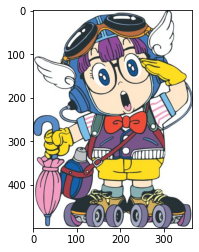

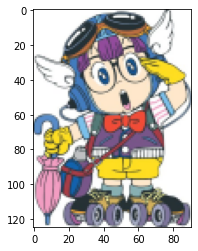

In [4]:
img_original = cv2.cvtColor(cv2.imread('drslump.jpg'), cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img_original)
H,W,CH = img_original.shape

DOWNSAMPLE = 4
img_small = cv2.resize(img_original, (W//DOWNSAMPLE, H//DOWNSAMPLE), interpolation = cv2.INTER_AREA)
plt.figure()
plt.imshow(img_small)

Now, lets define a keypoint with a large support region.

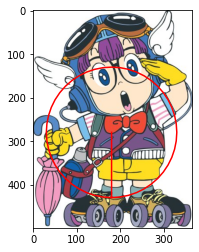

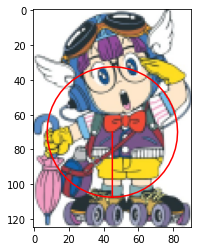

In [5]:
def show_lafs(img, lafs, idx=0, color='r', figsize = (10,7)):
    x,y = KF.laf.get_laf_pts_to_draw(lafs, idx)
    plt.figure(figsize=figsize)
    if (type(img) is torch.tensor):
        img_show = K.tensor_to_image(img)
    else:
        img_show = img
    plt.imshow(img_show)
    plt.plot(x, y, color)
    return

device = torch.device('cpu')

laf_orig  = torch.tensor([[150., 0, 180],
                     [0, 150, 280]]).float().view(1,1,2,3)
laf_small = laf_orig / float(DOWNSAMPLE)

show_lafs(img_original, laf_orig, figsize=(6,4))
show_lafs(img_small, laf_small, figsize=(6,4))

Now lets compare how extracted patch would look like when extracted in a naive way and from scale pyramid.

In [6]:
PS = 32
with torch.no_grad():
    timg_original = K.image_to_tensor(img_original, False).float().to(device) / 255.
    patches_pyr_orig = KF.extract_patches_from_pyramid(timg_original,laf_orig.to(device), PS)
    patches_simple_orig = KF.extract_patches_simple(timg_original, laf_orig.to(device), PS)
    
    timg_small = K.image_to_tensor(img_small, False).float().to(device)/255.
    patches_pyr_small = KF.extract_patches_from_pyramid(timg_small, laf_small.to(device), PS)
    patches_simple_small = KF.extract_patches_simple(timg_small, laf_small.to(device), PS)
    
# Now we will glue all the patches together:

def vert_cat_with_margin(p1, p2, margin=3):
    b,n,ch,h,w = p1.size()
    return torch.cat([p1, torch.ones(b, n, ch, h, margin).to(device), p2], dim=4)

def horiz_cat_with_margin(p1, p2, margin=3):
    b,n,ch,h,w = p1.size()
    return torch.cat([p1, torch.ones(b, n, ch, margin, w).to(device), p2], dim=3)

patches_pyr = vert_cat_with_margin(patches_pyr_orig, patches_pyr_small)
patches_naive = vert_cat_with_margin(patches_simple_orig, patches_simple_small)

patches_all = horiz_cat_with_margin(patches_naive, patches_pyr)

Now lets show the result. 
Top row is what you get if you are extracting patches without any antialiasing - note how the patches extracted from the images of different sizes differ.

Bottom row is patches, which are extracted from images of different sizes using a scale pyramid. They are not yet exactly the same, but the difference is much smaller.

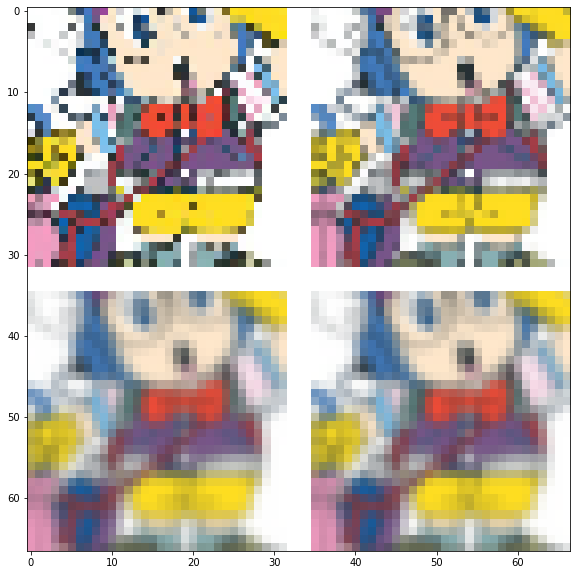

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(K.tensor_to_image(patches_all[0,0]))

Lets check how much it influences local descriptor performance such as HardNet

In [8]:
hardnet = KF.HardNet(True).eval()
all_patches = torch.cat([patches_pyr_orig,
                         patches_pyr_small,
                         patches_simple_orig,
                         patches_simple_small], dim=0).squeeze(1).mean(dim=1,keepdim=True)
with torch.no_grad():
    descs = hardnet(all_patches)
    distances = torch.cdist(descs, descs)
    print (distances.cpu().detach().numpy())

[[0.         0.09264624 0.8155752  0.5459374 ]
 [0.09264624 0.         0.7833668  0.5068493 ]
 [0.8155752  0.7833668  0.         0.4481334 ]
 [0.5459374  0.5068493  0.4481334  0.        ]]


So the descriptor difference between antialiased patches is 0.09 and between naively extracted -- 0.44